# Hedonmeter vs Word2vec

This work is to compare word ranking generated by crowdsourcing and word ranking generated by concept vector.  For the comparison of the two rankings, I will use [Spearman's rho correlational coefficients](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

- Date: 12/02/2015
- Author: Deok Gun Park


## Hedonmeter
Link: http://hedonometer.org/index.html

### Example Data
word  |	happiness_rank	| happiness_average	| happiness_standard_deviation	| twitter_rank | 	google_rank |	nyt_rank |	lyrics_rank
-----|----------------|----------|------------|-------------|-------|---------|----------|
laughter	| 1 |	8.50	| 0.9313	| 3600	| --	| --	| 1728
happiness	| 2 |	8.44	| 0.9723	| 1853	| 2458	| --	| 1230
love	| 3 |	8.42	| 1.1082	| 25	| 317	| 328	| 23

## Word2vec
Link: https://code.google.com/p/word2vec/


### 1. Import Library

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
%matplotlib inline

### 2. Load Dataset 

#### Parameters

In [26]:
# Location of required dataset
hedonFileName = './data/hedonmeter.TXT'
w2vModelFileName = './data/model.matrix'
w2vLabelFileName = './data/model.label'

In [27]:
hedon = pd.read_csv(hedonFileName, sep='\t', header=0, skiprows=3)
w2vLabel = open(w2vLabelFileName).read().split('\n')
w2vLabel = [w.rstrip() for w in w2vLabel ]

#There is an error. It reads additional blank line. So remove here. 
w2vLabel.pop()

w2vModel = pd.read_csv(w2vModelFileName, sep='\t', header=None)

#There is an error.  It reads one additional dimension. So remove here. 
w2vModel = w2vModel.drop(300,1)

w2vModel['word'] = pd.Series(w2vLabel, index=w2vModel.index)

In [17]:
# Test space for Loading
# Try uncomment some of below code

# hedon.head()
len(w2vLabel)
# w2vLabel[3000000]
len(w2vLabel)
# w2vModel['word'] = pd.Series(w2vLabel, index=w2vModel.index)
# w2vModel.head()

3000000

### 3. Find common words between two sets

In [19]:
# Iterate over hedon words and 
# If there is a same word in word2vec
# Add to the common words list 

common_words = []
hedon_words = hedon['word'].tolist()

counter = 0
for w in hedon_words:
    if w in w2vLabel:
        common_words.append(w)
    else:
#         print w
        counter += 1

print 'Common words generated.'
print str(counter) + ' words were skipped'

Common words generated.
374 words were skipped


### 4. Get Ranking for the Word2Vec

Here the **common_words** represents ranking in the hedon ranking.  So we need to calculate the ranking for the word2vec case. To do this, 
1. We will filter w2vModel by the common_words
2. We will generate concept vector
    - by the single word {happy, sad}
    - by the group of words that were at the beginning 100 words and bottom 100 words
3. We will calculate the cosine similarity between concept vector and normal vector
4. We will sort and get the new ranking


#### Parameters

In [173]:
# Parameters

groupSize = 1000 

positive_term = 'happy'
negative_term = 'sad'

In [177]:
# 1. We will filter w2vModel by the common_words
# Remove w2vModel to save some memory
if 'w2vModel' in locals():
    filteredW2vModel = w2vModel[w2vModel['word'].isin(common_words)]
    del w2vModel



In [178]:
'w2vModel' in locals()

False

In [179]:
# 2. We will generate concept vector for both single and group
# First we will do single case
positive_terms = [positive_term]
negative_terms = [negative_term]

positive_terms_models = filteredW2vModel[filteredW2vModel['word'].isin(positive_terms)].mean()[0:300]
negative_terms_models = filteredW2vModel[filteredW2vModel['word'].isin(negative_terms)].mean()[0:300]

concept_vector_single = positive_terms_models - negative_terms_models

#Then we will do group case
positive_terms = common_words[0:groupSize]
negative_terms = common_words[-1*groupSize:]

positive_terms_models = filteredW2vModel[filteredW2vModel['word'].isin(positive_terms)].mean()[0:300]
negative_terms_models = filteredW2vModel[filteredW2vModel['word'].isin(negative_terms)].mean()[0:300]

concept_vector_group = positive_terms_models - negative_terms_models


In [180]:
# 3. We will calculate the cosine similarity between concept vector and normal vector

filteredW2vModel['cosine_similarity_single'] = np.array([ cosine(filteredW2vModel.iloc[i,0:300], concept_vector_single) for i in range(len(filteredW2vModel)) ])
filteredW2vModel['cosine_similarity_group'] = np.array([ cosine(filteredW2vModel.iloc[i,0:300], concept_vector_group) for i in range(len(filteredW2vModel)) ])
filteredW2vModel.head()

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,word,cosine_similarity_single,cosine_similarity_group,group_ranking
1533,-0.003673,-0.037652,-0.037216,0.025682,-0.009250,0.032211,0.041569,-0.070515,0.003047,-0.029599,...,0.002394,0.048316,0.039610,-0.009631,-0.026117,-0.015561,unique,0.983789,0.633184,1
3057,0.002406,0.007419,-0.034559,0.054844,0.039255,-0.052215,0.053341,-0.027610,-0.048458,0.062733,...,-0.033620,-0.002500,0.056722,-0.061981,0.000446,-0.040945,wonderful,1.003437,0.615636,2
3457,-0.033247,0.047946,0.019161,-0.006518,-0.012599,0.033772,-0.001553,-0.000009,0.073494,-0.035872,...,-0.067894,0.009668,0.090992,-0.045846,0.026598,-0.031322,experiences,0.984561,0.706225,3
2461,-0.086703,-0.060554,0.023568,-0.008558,0.057114,-0.081542,0.007655,-0.024772,-0.037330,0.062619,...,-0.043179,-0.001263,0.022880,0.008214,-0.029245,-0.044384,exciting,0.953178,0.666330,4
519,0.015299,-0.024281,-0.023491,-0.061985,0.028821,0.052510,-0.041258,-0.101071,0.012486,-0.020728,...,-0.061590,0.026057,0.073040,-0.056458,-0.002134,0.003430,experience,0.932619,0.704868,5


In [181]:
# 4. We will sort and get the new ranking
filteredW2vModel.sort_values(by='cosine_similarity_single', inplace=True)
filteredW2vModel['single_ranking'] = np.array([i+1 for i in range(len(filteredW2vModel))])

filteredW2vModel.sort_values(by='cosine_similarity_group', inplace=True)
filteredW2vModel['group_ranking'] = np.array([i+1 for i in range(len(filteredW2vModel))])
filteredW2vModel.head()

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,word,cosine_similarity_single,cosine_similarity_group,group_ranking,single_ranking
3057,0.002406,0.007419,-0.034559,0.054844,0.039255,-0.052215,0.053341,-0.027610,-0.048458,0.062733,...,-0.002500,0.056722,-0.061981,0.000446,-0.040945,wonderful,1.003437,0.615636,1,4663
1533,-0.003673,-0.037652,-0.037216,0.025682,-0.009250,0.032211,0.041569,-0.070515,0.003047,-0.029599,...,0.048316,0.039610,-0.009631,-0.026117,-0.015561,unique,0.983789,0.633184,2,3438
10557,-0.062389,-0.013987,-0.034817,0.085332,0.107873,-0.019723,-0.010817,-0.072452,-0.097005,0.072452,...,-0.031597,0.047697,-0.102238,-0.018616,-0.029987,fabulous,0.913686,0.661652,3,849
2461,-0.086703,-0.060554,0.023568,-0.008558,0.057114,-0.081542,0.007655,-0.024772,-0.037330,0.062619,...,-0.001263,0.022880,0.008214,-0.029245,-0.044384,exciting,0.953178,0.666330,4,1972
3155,0.076488,0.012238,0.002242,0.110822,0.047932,0.005439,0.031955,-0.071389,-0.016487,0.043003,...,-0.055751,-0.001689,0.085326,0.017762,-0.007564,gift,0.969152,0.681111,5,2680


### 5. Calculate Spearman's rho

In [182]:
rankings = pd.DataFrame(common_words, columns=['word'])
rankings['hedon'] = np.array([i+1 for i in range(len(rankings))])
rankings['single_ranking'] = np.array([filteredW2vModel[filteredW2vModel.word == w].single_ranking.values[0] for w in common_words  ])
rankings['group_ranking'] = np.array([filteredW2vModel[filteredW2vModel.word == w].group_ranking.values[0] for w in common_words  ])

In [183]:
print 'Single ranking:\t' + str( spearmanr(rankings['hedon'], rankings['single_ranking']))
print 'Group ranking:\t' + str( spearmanr(rankings['hedon'], rankings['group_ranking']))


Single ranking:	SpearmanrResult(correlation=0.24784502577185571, pvalue=9.3397125054852708e-138)
Group ranking:	SpearmanrResult(correlation=0.6666205943022766, pvalue=0.0)


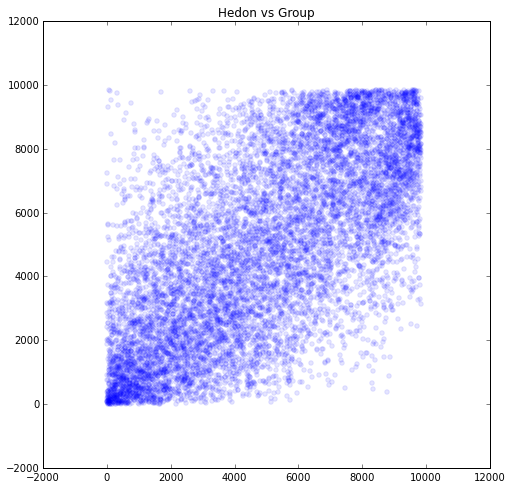

In [184]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, title="Hedon vs Group")
ax.scatter(rankings['hedon'], rankings['group_ranking'], color="blue", alpha=0.1)


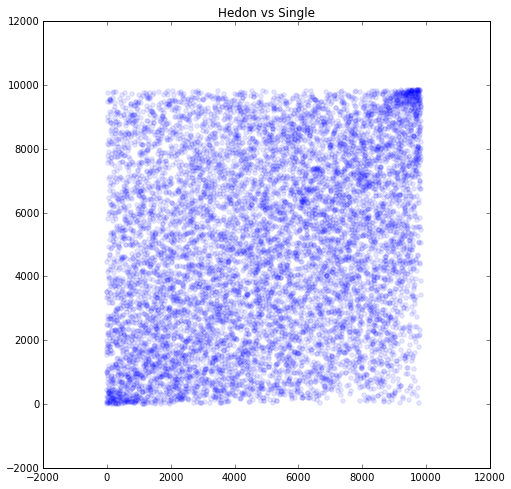

In [185]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, title="Hedon vs Single")
ax.scatter(rankings['hedon'], rankings['single_ranking'], color="blue", alpha=0.1)


In [186]:
filteredW2vModel = filteredW2vModel.drop('single_ranking',1)


In [187]:
filteredW2vModel

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,word,cosine_similarity_single,cosine_similarity_group,group_ranking
3057,0.002406,0.007419,-0.034559,0.054844,0.039255,-0.052215,0.053341,-0.027610,-0.048458,0.062733,...,-0.033620,-0.002500,0.056722,-0.061981,0.000446,-0.040945,wonderful,1.003437,0.615636,1
1533,-0.003673,-0.037652,-0.037216,0.025682,-0.009250,0.032211,0.041569,-0.070515,0.003047,-0.029599,...,0.002394,0.048316,0.039610,-0.009631,-0.026117,-0.015561,unique,0.983789,0.633184,2
10557,-0.062389,-0.013987,-0.034817,0.085332,0.107873,-0.019723,-0.010817,-0.072452,-0.097005,0.072452,...,-0.028779,-0.031597,0.047697,-0.102238,-0.018616,-0.029987,fabulous,0.913686,0.661652,3
2461,-0.086703,-0.060554,0.023568,-0.008558,0.057114,-0.081542,0.007655,-0.024772,-0.037330,0.062619,...,-0.043179,-0.001263,0.022880,0.008214,-0.029245,-0.044384,exciting,0.953178,0.666330,4
3155,0.076488,0.012238,0.002242,0.110822,0.047932,0.005439,0.031955,-0.071389,-0.016487,0.043003,...,0.040114,-0.055751,-0.001689,0.085326,0.017762,-0.007564,gift,0.969152,0.681111,5
1755,-0.000484,-0.018586,-0.108887,0.124656,0.005562,0.049187,0.074719,-0.022904,-0.058949,0.071715,...,-0.086734,-0.091615,-0.001056,-0.070589,0.116396,-0.057072,enjoy,0.795472,0.683001,6
10011,0.014805,0.049543,0.074315,0.005080,0.039673,-0.040834,0.073927,0.015192,0.052252,0.043931,...,-0.059606,-0.039480,0.080507,-0.054575,0.022546,0.082056,inspiring,1.058600,0.688353,7
6293,-0.083642,0.001069,-0.024315,0.050899,0.047008,-0.065488,0.084291,-0.114765,0.029178,0.089478,...,0.002320,-0.027395,-0.006768,0.022694,-0.020343,0.015237,dedication,0.978322,0.691991,8
2789,-0.029881,0.038342,-0.099364,0.065523,0.072723,-0.072363,-0.019621,-0.049322,-0.038162,0.102964,...,-0.153367,-0.123845,0.029161,-0.073803,0.083164,-0.054002,enjoyed,0.790276,0.692406,9
9344,-0.045900,0.010236,0.062852,0.093887,0.051899,0.071459,-0.018517,0.020733,-0.086063,-0.018908,...,0.057897,-0.059462,0.074588,-0.105362,0.067286,0.059984,recipes,0.884146,0.692781,10
